In [1]:
# import normal python libraries
import numpy as np
import glob
import xarray as xr
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy import stats

# imports for ML libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.layers import Add, Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization
from keras import backend as K 
from keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler


# Load Climate Model Data

In [2]:
def storer(set_of_files):
    """ 
    Function which returns X (predictor) and Y (target) data from processed large ensemble files.
    """
    X_data = []
    Y_data = []
    model_names = []
    for model in set_of_files:
        # get model name string
        model_name = model.split('/')[-1][:-3]
        
        # open model and take 1900-2050 data
        CM = xr.open_dataset(model)
        CM = CM.sel(period=slice(1900,2050))
        
        # get predictor and target data
        X_CM = CM.X_TAS_and_PSL.values # X_TAS_and_PSL refers to maps of surface air temp and sea level pressure
        Y_CM = CM.Y_I_E.values # Y_I_E refers to the float values of the Internally and Externally generated trends
        
        # append data
        X_data.append(X_CM)
        Y_data.append(Y_CM)
        CM.close()
        model_names.append(model_name)
    return(X_data, Y_data, model_names)


# define file path to historical and spliced simulations
cmip6_hist = glob.glob('../ModelData/CMIP6_70to90_historical/*')
cmip6_spliced = glob.glob('../ModelData/CMIP6_70to90_spliced/*')

# Delete the 'OthersAllEM' data, as we do not train on this "large ensemble"
cmip6_hist = [s for s in cmip6_hist if 'OthersAllEM' not in s] 
cmip6_spliced = [s for s in cmip6_spliced if 'OthersAllEM' not in s] 

# get historical simulations which do not have extension past 2014
hist_not_spliced = []
model_names = [cmip6_spliced[i].split('/')[2] for i in range(len(cmip6_spliced))]
for filename in cmip6_hist:
    model_name = filename.split('/')[2]
    extended_models = [cmip6_spliced[i].split('/')[2] for i in range(len(cmip6_spliced))]
    if model_name in extended_models:
        continue
    else:
        hist_not_spliced.append(filename)
        
# store data
hist_no_splice_X, hist_no_splice_Y, model_names_hist_no_splice = storer(hist_not_spliced)
splice_X, splice_Y, model_names_spliced = storer(cmip6_spliced)

# use all latitudes as predictors in the global case
hist_no_splice_X_cut = []
splice_X_cut = []
for data in hist_no_splice_X:
    data_to_keep = data[:,:,:,:,:]
    hist_no_splice_X_cut.append(data_to_keep)
for data in splice_X:
    data_to_keep = data[:,:,:,:,:] 
    splice_X_cut.append(data_to_keep)

# free up space
del hist_no_splice_X
del splice_X

# reorganize models by their arctic warming over the 1980-2022 period
models_reorgainzed = ['CESM2_SBMB', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'CanESM5']
ranked_arctic_warming_indices = []
for model_name in models_reorgainzed:
    new_ranked_indices = model_names_spliced.index(model_name)
    ranked_arctic_warming_indices.append(new_ranked_indices)
splice_X_cut = [splice_X_cut[i] for i in ranked_arctic_warming_indices]
splice_Y = [splice_Y[i] for i in ranked_arctic_warming_indices]
model_names_spliced = [model_names_spliced[i] for i in ranked_arctic_warming_indices]
    

# Load Observations

In [ ]:
TAS_observations_names = ['HadCRUTv5', 'BerkeleyEarth', 'GISTEMPv4', 'NOAAv5']
SLP_observations_names = ['ERA5', 'JRA55', 'MERRA2']

TAS_observations = [np.load('../Observations/{obs_name}_TAS.npy'.format(obs_name=name)) for name in TAS_observations_names]
SLP_observations = [np.load('../Observations/{obs_name}_SLP.npy'.format(obs_name=name)) for name in SLP_observations_names]
obs_maps = []
for tas_array in TAS_observations:
    for slp_array in SLP_observations:
        tas_and_slp_maps = np.stack([tas_array, slp_array], axis=-1)
        obs_maps.append(tas_and_slp_maps)
obs_maps = np.array(obs_maps)[:,:,:,:] 

# Train Model

In [4]:
def create_CNN(parameters):
    f_size, k_size, p_size, d_size, e_size = parameters
    
    # input layer 
    inpt = layers.Input(shape=(72, 144, 2))
    
    # convolutional layer
    conv = Conv2D(f_size, k_size, padding='same', activation='relu')(inpt)
    
    # pooling layer
    pool = layers.MaxPooling2D(p_size)(conv)
    
    # dropout layer
    drop = layers.Dropout(d_size)(pool)
    
    # flattening layer 
    flat = layers.Flatten()(drop)
    
    # dense output layer 
    out = layers.Dense(2)(flat)
    
    # create model
    model = Model(inputs=inpt, outputs=out)
    
    return(model)

# define min max scalers for use
Xscale = MinMaxScaler()
Yscale = MinMaxScaler()

# create arrays for which to store result
cv_preds_and_vals_one_cnn = []
cv_obs_one_cnn = []
cv_mse_one_cnn = []
prediction_error = []
spreads_all_preds = []

# loop through each large ensemble we test on (cv = cross validation)
for cv in range(len(splice_X_cut)):
    print('Cross Validation Index: ', cv)
    cv_preds_and_vals_one_randomization = []
    cv_obs_one_randomization = []
    for randomization in range(50):
        # equally weight training data from different models
        splice_X_10ens = []
        splice_Y_10ens = []
        hist_X_10ens = []
        hist_Y_10ens = []

        # bootstrap 10 ensemble members to train on from models with more than 10 members
        # first do this for the data which has extensions past 2014
        for model_idx in range(len(splice_X_cut)):
            model_X = splice_X_cut[model_idx]
            model_Y = splice_Y[model_idx]
            random_indices = np.random.choice(range(0, len(model_X)), size=10, replace=True)
            splice_X_10ens.append(model_X[random_indices])
            splice_Y_10ens.append(model_Y[random_indices])
        # then, do this for data which does not have extensions
        for model_idx in range(len(hist_no_splice_X_cut)):
            model_X = hist_no_splice_X_cut[model_idx]
            model_Y = hist_no_splice_Y[model_idx]
            random_indices = np.random.choice(range(0, len(model_X)), size=10, replace=True)
            hist_X_10ens.append(model_X[random_indices])
            hist_Y_10ens.append(model_Y[random_indices])

        # define training data
        X_train_spliced = np.concatenate(np.delete(splice_X_10ens, cv, axis=0), axis=0)
        Y_train_spliced = np.concatenate(np.delete(splice_Y_10ens, cv, axis=0), axis=0)
        X_train_hist = np.concatenate(hist_X_10ens, axis=0)
        Y_train_hist = np.concatenate(hist_Y_10ens, axis=0)

        # reshape to put ensembles and time periods in same axis
        X_train_spliced = X_train_spliced.reshape(X_train_spliced.shape[0]*X_train_spliced.shape[1], X_train_spliced.shape[2], X_train_spliced.shape[3], X_train_spliced.shape[4])
        X_train_hist = X_train_hist.reshape(X_train_hist.shape[0]*X_train_hist.shape[1], X_train_hist.shape[2], X_train_hist.shape[3], X_train_hist.shape[4])
        Y_train_spliced = Y_train_spliced.reshape(Y_train_spliced.shape[0]*Y_train_spliced.shape[1], Y_train_spliced.shape[2])
        Y_train_hist = Y_train_hist.reshape(Y_train_hist.shape[0]*Y_train_hist.shape[1], Y_train_hist.shape[2])

        # concatenate and reshape training data
        X_train = np.concatenate([X_train_spliced, X_train_hist], axis=0)
        Y_train = np.concatenate([Y_train_spliced, Y_train_hist], axis=0)
        X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
        Y_train_reshaped = Y_train[:,:2]

        # define testing data, the -6 time period is 1980-2022 which is our testing period
        X_test = splice_X_cut[cv][:,-6]
        X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3])
        Y_test = splice_Y[cv][:,-6,:]
        Y_test = Y_test[:,:2]

        # scale training and testing data
        Xscale.fit(X_train_reshaped)
        Yscale.fit(Y_train_reshaped)
        X_train_scaled = Xscale.transform(X_train_reshaped)
        X_test_scaled = Xscale.transform(X_test_reshaped)
        Y_train_scaled = Yscale.transform(Y_train_reshaped)
        Y_test_scaled = Yscale.transform(Y_test)

        # put data back into sample x map x channel shape
        X_train_map = np.reshape(X_train_scaled, (X_train.shape))
        X_test_map = np.reshape(X_test_scaled, (X_test.shape))

        # create and fit the model
        model = create_CNN([48, (3,7), 1, 0.5, 5])
        model.compile(loss="mse", optimizer=optimizers.Adam(learning_rate=1e-4))
        model.fit(X_train_map, Y_train_scaled, epochs=5, verbose=0, batch_size=16, shuffle=True)
        
        # make predictions on testing data
        Y_pred_scaled = model.predict(X_test_map)
        Y_preds_unscaled = Yscale.inverse_transform(Y_pred_scaled)
        Y_pred = np.transpose(Y_preds_unscaled).tolist()
        Y_test_one_model = np.transpose(Y_test).tolist()
        sum_preds = np.nansum(Y_pred, axis=0)
        sum_test = np.nansum(Y_test_one_model, axis=0)
        Y_pred.append(sum_preds)
        Y_test_one_model.append(sum_test)
        cv_preds_and_vals_one_randomization.append([np.transpose(Y_pred), np.transpose(Y_test_one_model)])

        # make predictions on observations
        X_obs_reshaped = obs_maps.reshape(obs_maps.shape[0], obs_maps.shape[1]*obs_maps.shape[2]*obs_maps.shape[3])
        X_obs_scaled = Xscale.transform(X_obs_reshaped)
        X_obs_map = np.reshape(X_obs_scaled, (obs_maps.shape))
        obs_Y_pred_scaled = model.predict(X_obs_map)
        obs_Y_pred_unscaled = Yscale.inverse_transform(obs_Y_pred_scaled)
        Y_obs = np.transpose(obs_Y_pred_unscaled).tolist()
        sum_obs = np.nansum(Y_obs, axis=0)
        Y_obs.append(sum_obs)
        cv_obs_one_randomization.append(Y_obs)

    # check what the spread is for the 50 different CNNs
    cv_preds_and_vals_one_randomization = np.array(cv_preds_and_vals_one_randomization)
    spread_preds = []
    for n_ens in range(0, len(cv_preds_and_vals_one_randomization[0,0,:,0])):
        spread_per_pred = np.nanstd(cv_preds_and_vals_one_randomization[:,0,n_ens,:], axis=0)
        spread_preds.append(spread_per_pred)
    spreads_all_preds.append(spread_preds)
    
    # find mean prediction from all CNNs
    mean_of_randomizations_val = np.nanmean(cv_preds_and_vals_one_randomization, axis=0)
    mean_of_randomizations_obs = np.nanmean(cv_obs_one_randomization, axis=0)
    error = mean_of_randomizations_val[0] - mean_of_randomizations_val[1]
    prediction_error.append(error)
    mse_of_cv = [np.nanmean(np.square(error[:,i])) for i in range(3)]

    cv_preds_and_vals_one_cnn.append(mean_of_randomizations_val)
    cv_obs_one_cnn.append(mean_of_randomizations_obs)
    cv_mse_one_cnn.append(mse_of_cv)

0
1
2
3
4
5
6


In [7]:
cv_preds_and_vals = cv_preds_and_vals_one_cnn
cv_obs = np.array(cv_obs_one_cnn)

In [8]:
# find weighted standard deviation of errors, where weight comes from amount of members in ensemble
weighted_errors = []
for error in prediction _error: 
    squared_error = np.multiply(error, error)
    weighted_sqrd_error = squared_error*(1/len(squared_error))
    weighted_errors.append(weighted_sqrd_error)
weighted_errors_all = np.concatenate(weighted_errors)
weighted_errors_all_sum = np.nansum(weighted_errors_all, axis=0)
weighted_errors_all_mean = weighted_errors_all_sum/7 # divide by 7 because all weights added up equal 7
new_errors_std = np.sqrt(weighted_errors_all_mean) # take sqrt because you currently have the squared error

[0.02082678 0.01923486 0.00721971]


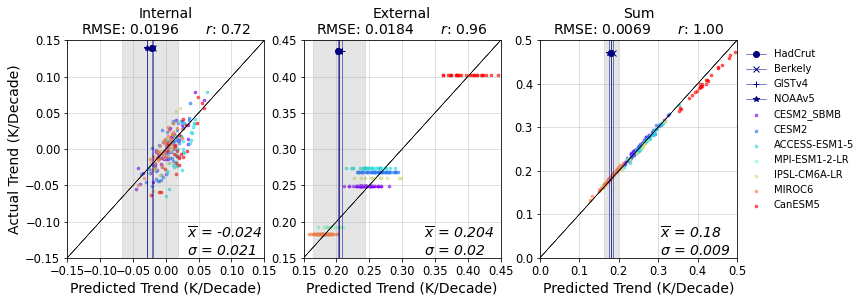

In [11]:
# Create labels and colors
titles = ['Internal', 'External', 'Sum']
obs_labels = ['HadCrut', 'Berkely', 'GISTv4', 'NOAAv5']
obs_markers = ['o', 'x', '+', '*', 'd']
marker_loc = [0.14, .435, .47]
colors = cm.rainbow(np.linspace(0, 1, 7))

# make subplot
fig, axs = plt.subplots(1,3, figsize=(12,4), facecolor='white')

# select cv data
cv_obs_1 = np.swapaxes(cv_obs, 0,2)
cv_obs_1_by_obs = np.reshape(cv_obs_1, (4,3,3,7))


for trend_comp in range(3):
    # ravel all observational estimates from cv for a given component and find mean/spread and plot it
    all_obs_spread = np.nanmean(cv_obs_1_by_obs[:,:,trend_comp,:], axis=2).ravel()
    all_obs_mean = np.nanmean(all_obs_spread)
    all_obs_sigma = np.nanstd(all_obs_spread)
    sigma_2 = new_errors_std[trend_comp]
    all_obs_sigma = np.sqrt(all_obs_sigma**2 + sigma_2**2)
    obs_mean = str(round(all_obs_mean, 3))
    obs_std = str(round(all_obs_sigma, 3))
    axs[trend_comp].axvspan(all_obs_mean - 2*all_obs_sigma, all_obs_mean + 2*all_obs_sigma, color='grey', alpha=0.2)
    text_item = '$\overline{x}$ = ' + obs_mean + '\n$\sigma$ = ' + obs_std
    axs[trend_comp].text(0.61, 0.15, text_item, transform=axs[trend_comp].transAxes,
            fontsize=14, style='italic', va='top', ha='left')

# for each iteration of the cross validation find predictions and validations (test)
for model_idx, set_of_preds_and_vals in enumerate(cv_preds_and_vals):
    Y_pred_ = np.array(set_of_preds_and_vals[0])
    Y_test_ = np.array(set_of_preds_and_vals[1])

    for trend_comp in range(3):
        # for each component of trend, plot the scatter
        axs[trend_comp].scatter(Y_pred_[:,trend_comp], Y_test_[:,trend_comp], color=colors[model_idx], s=7, alpha=0.6, label=model_names_spliced[model_idx])
        
        # also plot the prediction = validation line
        axs[trend_comp].plot(np.linspace(-2,2.5), np.linspace(-2,2.5), color='black', linewidth=0.25)
        
        # use varying x and y lims for each component
        if trend_comp == 0:
            ticks = np.arange(-0.15,0.151, 0.05)
            axs[trend_comp].set_xticks(ticks)
            axs[trend_comp].set_yticks(ticks)
            axs[trend_comp].set_ylim(ticks[0],ticks[-1])
            axs[trend_comp].set_xlim(ticks[0],ticks[-1])
        if trend_comp == 1:
            ticks = np.arange(0.15,0.451, 0.05)
            axs[trend_comp].set_xticks(ticks)
            axs[trend_comp].set_yticks(ticks)
            axs[trend_comp].set_ylim(ticks[0],ticks[-1])
            axs[trend_comp].set_xlim(ticks[0],ticks[-1])
        if trend_comp == 2:
            ticks = np.arange(-0.0,0.51, 0.1)
            axs[trend_comp].set_xticks(ticks)
            axs[trend_comp].set_yticks(ticks)
            axs[trend_comp].set_ylim(ticks[0],ticks[-1])
            axs[trend_comp].set_xlim(ticks[0],ticks[-1])
            
        # for each set of observations, find the mean
        if model_idx == len(cv_preds_and_vals) - 1:
            cv_obs_set = cv_obs_1_by_obs[:,:,trend_comp,:]
            cv_obs_set = np.reshape(cv_obs_set, (4,3*7))
            
            for obs_set_idx in range(len(cv_obs_set)):
                obs_set_all_cv = cv_obs_set[obs_set_idx]
                mean_obs = np.nanmean(obs_set_all_cv)
                y_spacing = axs[trend_comp].get_ylim()
                axs[trend_comp].plot(np.repeat(mean_obs, 3), [-5, marker_loc[trend_comp], 5], color='navy', marker=obs_markers[obs_set_idx], label=obs_labels[obs_set_idx], linewidth=0.5)

# Give scores across all models and ensemble members from 1980-2022 period
all_preds_and_vals = np.concatenate(cv_preds_and_vals, axis=1)
for trend_comp in range(3):
    # Again, get predictions and validations
    Y_pred_ = all_preds_and_vals[0]
    Y_test_ = all_preds_and_vals[1]

    # find MSE for trend components
    MSE = np.nanmean(np.square(Y_pred_[:,trend_comp] - Y_test_[:,trend_comp]), axis=0)
    MSE_str = str(np.around(MSE,5))
    
    # find r for trend components
    r = stats.pearsonr(Y_pred_[:,trend_comp], Y_test_[:,trend_comp])[0]

    # put MSE and r in title
    axs[trend_comp].set_title(titles[trend_comp] + '\nRMSE: {:.4f}'.format(round(np.sqrt(MSE),4))  + '      $r$: {:.2f}'.format(round(r,2)), fontsize=14)

    # put labels on plots
    axs[trend_comp].set_xlabel('Predicted Trend (K/Decade)', fontsize=14)
    axs[0].set_ylabel('Actual Trend (K/Decade)', fontsize=14)
    axs[trend_comp].grid(alpha=0.5)
    axs[trend_comp].tick_params(axis='both', labelsize=11.5)

axs[2].legend(loc='upper left', bbox_to_anchor=(1., 1.0), frameon=False)

#plt.savefig('../figures/CNN_Global_4TAS_3SLP_1900_on.png', dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
